# CLIP 유사도 Matrix

> 런타임 유형 꼭 GPU 설정하기

> 빈칸을 채우고 실행하는 문제입니다.



In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-z7ffelvk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-z7ffelvk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install ftfy regex tqdm
!pip install seaborn

In [3]:
import os
import torch
import clip
from PIL import Image
import torch.nn.functional as F

# 1. 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 2. CLIP 모델 불러오기
model, preprocess = clip.load("ViT-B/32", device=device)

# 3. 이미지 파일 목록 (./images 폴더에 저장되어 있어야 함)
image_filenames = [
    "cat.jpg",
    "dog.jpg",
    "car.jpg",
    "pizza.jpg",
    "guitar.jpg"
]
image_paths = [os.path.join("./images", f) for f in image_filenames]

# 4. 텍스트 프롬프트
# 기존 텍스트 + distractor 프롬프트 추가
text_prompts = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a car",
    "a photo of a pizza",
    "a photo of a guitar",
    "a photo of a horse",
    "a photo of a hamburger",
    "a photo of a piano"
]


# 5. 이미지 전처리 및 배치
image_tensors = [preprocess(Image.open(img_path).convert("RGB")) for img_path in image_paths]
image_input = torch.stack(image_tensors).to(device)

# 6. 텍스트 토큰화
text_tokens = clip.tokenize(text_prompts).to(device)

# 7. 특징 추출 (with torch.no_grad for inference)
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_tokens)

# 8. 정규화 (cosine similarity 위해 L2 normalization)
image_features = F.normalize(image_features, dim=1)
text_features = F.normalize(text_features, dim=1)

# 9. cosine similarity matrix 계산 (5x5)
similarity_matrix = image_features @ text_features.T

# 10. 출력
print("Cosine Similarity Matrix (Image × Text):")
print(similarity_matrix)

# 선택: 가장 유사한 텍스트 인덱스 출력
best_matches = similarity_matrix.argmax(dim=1)
for i, idx in enumerate(best_matches):
    print(f"Image {image_filenames[i]} → {text_prompts[idx]}")


100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 52.5MiB/s]


Cosine Similarity Matrix (Image × Text):
tensor([[0.2893, 0.2261, 0.1946, 0.1799, 0.1746, 0.2081, 0.1825, 0.1600],
        [0.2126, 0.2852, 0.1927, 0.2006, 0.1847, 0.2267, 0.2053, 0.1851],
        [0.1313, 0.1490, 0.2239, 0.1155, 0.1276, 0.1339, 0.1206, 0.1311],
        [0.1316, 0.1416, 0.1602, 0.2627, 0.1531, 0.1517, 0.1713, 0.1548],
        [0.1985, 0.1917, 0.1719, 0.1895, 0.2971, 0.1890, 0.1450, 0.1766]],
       device='cuda:0', dtype=torch.float16)
Image cat.jpg → a photo of a cat
Image dog.jpg → a photo of a dog
Image car.jpg → a photo of a car
Image pizza.jpg → a photo of a pizza
Image guitar.jpg → a photo of a guitar


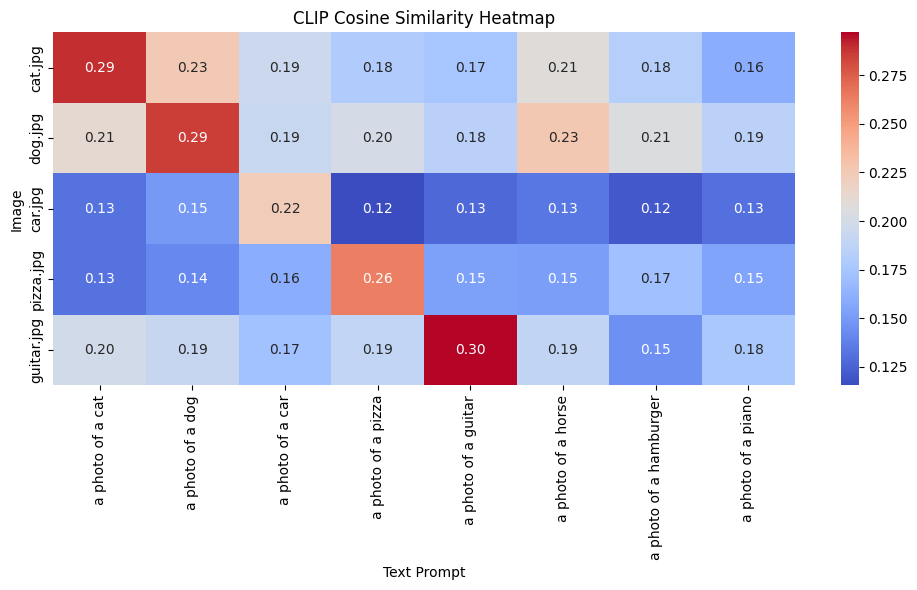

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 텍스트 & 이미지 라벨
labels = [
    "cat", "dog", "car", "pizza", "guitar"
]

# 2. similarity_matrix는 torch.Tensor → numpy로 변환
sim_matrix_np = similarity_matrix.cpu().numpy()

# 3. 히트맵 시각화
# 3. 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(sim_matrix_np,
            xticklabels=text_prompts,
            yticklabels=image_filenames,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            cbar=True)

plt.xlabel("Text Prompt")
plt.ylabel("Image")
plt.title("CLIP Cosine Similarity Heatmap")
plt.tight_layout()
plt.show()

In [5]:
# 정답 인덱스 (앞의 5개 프롬프트가 정답쌍이라고 가정)
true_indices = torch.tensor([0, 1, 2, 3, 4]).to(device)

# Top-1 prediction
pred_indices = similarity_matrix.argmax(dim=1)

# Top-1 Accuracy
accuracy = (pred_indices == true_indices).float().mean().item()
print(f"\nTop-1 Accuracy: {accuracy * 100:.2f}%")



Top-1 Accuracy: 100.00%


In [8]:
# 각 이미지별로 유사도 높은 텍스트 상위 3개 인덱스 가져오기
top3_indices = similarity_matrix.topk(3, dim=1).indices

# Top-3 Accuracy 계산
top3_correct = torch.zeros(len(true_indices)).to(device)

for i in range(len(true_indices)):
    if true_indices[i] in top3_indices[i]:
        top3_correct[i] = 1.0

top3_accuracy = top3_correct.mean().item()
print(f"Top-3 Accuracy: {top3_accuracy * 100:.2f}%")

Top-3 Accuracy: 100.00%


#CLIP의 Cosine Similarity Heatmap 결과를 보고 정답쌍과 오답쌍의 유사도 차이가 어떻게 나타났는지 분석하시오. 또한 이러한 결과가 나타난 이유를 추론해보세요.


답:정답쌍은 높은 유사도를, 오답쌍은 낮은 유사도를 나타낸다.
CLIP이 이미지와 텍스트 간 의미적 연관성을 효과적으로 학습했기 때문입니다.